In [1]:
import requests
from shapely.geometry import Polygon, LineString, Point, MultiPolygon, MultiLineString, MultiPoint
from shapely.ops import linemerge
import shapely
import pandas as pd
import re
import time
from multiprocessing import Pool, current_process

In [2]:
# TODO's:
# - second
# I want to make the disection multithread able espacialy in context of the first
# todo this would I think immensily speed up the proccesing of the osm data
# the dataframe could be the common data storage for all threads
# and if one of the threads has solved a geomtry and stored it back in the dataframe
# the other threads can retrieve it and don't even need to solve it themselfs

In [3]:
overpass_url = "http://overpass-api.de/api/interpreter"
thread_count = 8 

In [16]:
def generate_querry_poly(poly):
    # this function takes a shapely polygon and makes
    # an overpass filter polygon out of it
    # for the querry we will only support simple polygon
    # - no multipolygons and 
    # - no inner rings
    # because overpass does not support it
    # https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL#By_polygon_.28poly.29
    
    #test if polygon conforms
    assert isinstance(poly, shapely.geometry.polygon.Polygon), f'polygon is of {type(poly)} only shapely.geometry.polygon.Polygon is supported'
    assert not list(poly.interiors), 'polygon has inner rings this is not supported by overpass filters' 
    
    #simplyfy polygon if down to 101 cordinate pairs complex
    while len(list(poly.exterior.coords)) >= 101:
        # 0.1 is quite aggressive maybe 0.01 also works
        poly = poly.simplify(0.1, preserve_topology=True)
    
    # extracts the exterior coords and puts them into a string
    poly_string = ' '.join([f'{lat:.6f} {lon:.6f}' for lon,lat in list(poly.exterior.coords)])
    
    return poly_string


def json_from_osm(poly, mode='nwr', key=None, value=None, operand='='):
    
    kv_filter = ''
    if key:
        kv_filter = f'["{key}"]'
    if value:
        assert key, "you can't pass a value without a key"
        kv_filter = f'{kv_filter[:-1]}{operand}"{value}"]'

    query = f'''
            [out:json][timeout:25];
            (
              {mode}{kv_filter}(poly:"{generate_querry_poly(poly)}");
            );
            out body;
            >;
            out skel qt;
            '''

    respones = get_data(overpass_url,query)

    return respones.json()


def get_data(overpass_url,query):
    
    # currently there are only 2 slots available on a timer so we have to 
    # check if there is an open slot
    
    if 'overpass-api.de' in overpass_url:
        wait_for_slot()
    
    respones = requests.get(overpass_url, params={'data': query})
    
    if 'The server is probably too busy to handle your request' in respones.text:
        # server seems to be busy we wait for a second
        # and try again
        print('overpass server is busy')
        time.sleep(1)
        respones = get_data(overpass_url,query)
    
    assert respones.ok, respones.text
    
    return respones


def wait_for_slot():
    status_url = "https://overpass-api.de/api/status/"
    respones = requests.get(status_url)
    
    if not 'slots available now' in respones.text:
        # find all blocked slots and how long we have to wait for them
        try:
            l = [int(seconds) for seconds in re.findall(r'(?<=in )(\d*)(?= seconds)', respones.text)]
            l.sort()
            sleep_t = l[0]+1
            print(f'next open slot in {sleep_t} seconds waiting till then')
            time.sleep(sleep_t)
            wait_for_slot()
        except:
            print(respones.text)
            time.sleep(10)
            wait_for_slot()


class disect_osm:
    # when parsing osm data there exists a hugh issue with relations 
    # because they can contain multiple differnt kinds of geometries 
    # like polygons, lines, and points in the same thing they can even contain other
    # relations that then again contain different types of geometries
    # most osm parsers fail here
    # so my idea is to split every relation into its most basic components
    # so we get all features of relation a grouped by geometries type togehter 
    # with all the tags of realtion the relation
    # for this i need to drill done every relation until I hit the the basic geometries
    # points lines polygons and special case multiploygon
    
    def __init__(self, osm_json, cache_nodes=True):
        self.osm_json = osm_json
        self.cache_nodes = cache_nodes
        # these are all the geometrie types features can have, relations can have multiple of those
        self.geometry_types = ['point','multipoint','line','multiline','polygon','multipolygon']
        self._parse_osm_json()
    
    def generate_geometry(self, f_type, osmid):
        # osmid within a feautre type are unique
        # but its possible that there is a node relation and way with id 467
        # select the feature in question from the df
        try:
            # recusion does some times fail when the feature refferenced wasn't retrieved from osm
            feature = self.feature_df.loc[(f_type,osmid)]
            geometry_ref = feature['geometry_ref']
            geometry = feature['geometry']
            
        except:
            # if we can not retriefe a feature we set everyting to none
            f_type = None
            geometry = None
        
        # test if the geometry is already pressent in solved form in the dataframe
        # if not we solve it otherwise we return what was fetched
        if (not geometry) and (f_type):
            
            if f_type == 'node':
                geometry = self._solve_node(geometry_ref)

            if f_type == 'way':
                geometry = self._solve_way(geometry_ref)

            if f_type == 'relation':
                if feature['tags']['type'] == 'multipolygon':
                    # Multipolygons are a special case for relations
                    # so they have thier own solver
                    geometry = self._solve_relation_multipolygon(geometry_ref)
                else:
                    geometry = self._solve_relation(geometry_ref) 

            # if the geometry wasnt before solved we put the solved form back into the dataframe
            # putting geometry into a list is a hack that gets around the ValueError: setting an array element with a sequence.
            # see https://stackoverflow.com/questions/26483254/python-pandas-insert-list-into-a-cell
            
            try:
                self.feature_df.at[(f_type,osmid), 'geometry'] = geometry
            except:
                print(geometry)
                xbreak()

        return geometry
    
    def _parse_osm_json(self,):

        with Pool(thread_count) as p:
            feature_list = p.map(self._parallel_parse, self.osm_json['elements'])
        
        self.feature_df = pd.DataFrame(feature_list, columns=['type','id','geometry_ref','geometry','tags'])
        # because of the type of Overpass QL querry  
        # see: https://help.openstreetmap.org/questions/78620/duplicate-features-retrieved-with-overpass-ql
        # some features are duplicated in the dataframe so here we merge them and combine the tags of them
        if len(self.feature_df) > 0:
            self.feature_df = self.feature_df.groupby(['type','id']).aggregate(self._agg_tags)#.reset_index().set_index(['type', 'id',])
            
    def _parallel_parse(self, element):
        if element['type'] == 'node':

            if self.cache_nodes:
                # since nodes are the basis of all the things and not reliant on other features
                # we solve them when the dataframe gets created
                feature = [element['type'],element['id'],None,self._solve_node((element['lon'],element['lat'])),]
            else:
                feature = [element['type'],element['id'],(element['lon'],element['lat']),None]

        elif element['type'] == 'way':
            feature = [element['type'],element['id'],element['nodes'],None]

        elif element['type'] == 'relation':
            feature = [element['type'],element['id'],element['members'],None]

        #not all elements have tags
        try:
            feature.append(element['tags'])                        
        except:
            feature.append(None) 

        return feature    
    
    def _agg_tags(self,x):
        # function aggregates multiple tags into one tags dictonary
        # for all other columns (that are not part of the groupby)
        # the first value is returned
        # this follows the apriori assumption all other values are the same anyway

        r_value = None
        if x.name == 'tags':
            _new_dict = {}
            for element in x:
                if type(element) == dict:
                    _new_dict = {**_new_dict, **element}

            if _new_dict:
                r_value = _new_dict
        
        else:
            r_value = x.iloc[0]
    
        return r_value    
    
    def _solve_node(self,lon_lat):
        
        return {'point':Point(lon_lat)}
    
    def _solve_way(self, node_list):
        
#         with Pool(thread_count) as p:            
#             point_geometries = p.map(self._parrallel_geometry_way, node_list)
        point_geometries = [self.generate_geometry('node',node_id) for node_id in node_list]
        # now we filter out the none
        point_geometries = [geom['point'] for geom in point_geometries if geom]
        

        if not point_geometries:
            geom = None
        
        # its a polygon if first and last element are the same and has more than 
        # 2 coordinate pairs
        elif (point_geometries[0] == point_geometries[-1]) and (len(point_geometries) > 2):
            temp_poly = Polygon(point_geometries)

            # simple fix for invalid polygons
            if not temp_poly.is_valid:
                temp_poly = temp_poly.buffer(0)
            
            geom = {'polygon':temp_poly} 
        
        # for a line we need atleast 2 points
        elif len(point_geometries) > 1:
            geom = {'line':LineString(point_geometries)}
            
        else:
            # if we arive here ther might be something wrong with the way
            # so better to not return it at all
            geom = None
            
        return geom
    
    def _parrallel_geometry_way(self, node_id):
        print(current_process())
        return self.generate_geometry('node',node_id)
    
    
    def _solve_relation(self, member_list):
        geom = {'multipoint':[],
                'multiline':[],
                'multipolygon':[]}
        
        for member in member_list:
            member_geom = self.generate_geometry(member['type'],member['ref'])

                
            if not member_geom:
                # if no geometrie for this member can be found we skip it
                continue
            
            # since a member can also be a relation it can have multiple 
            # geometry types
            for geom_type in member_geom:
                if geom_type == 'point':
                    geom['multipoint'].append(member_geom[geom_type])
                if geom_type == 'multipoint':
                    # multi features need to split to be later be put togehter again
                    [geom['multipoint'].append(point) for point in list(member_geom[geom_type])]      
                
                if geom_type == 'line':
                    geom['multiline'].append(member_geom[geom_type])
                if geom_type == 'multiline':
                    # multi features need to split to be later be put togehter again
                    [geom['multiline'].append(line) for line in list(member_geom[geom_type])]    
                
                if geom_type == 'polygon':
                    geom['multipolygon'].append(member_geom[geom_type])
                if geom_type == 'multipolygon':
                    # multi features need to split to be later be put togehter again
                    [geom['multipolygon'].append(poly) for poly in list(member_geom[geom_type])] 
                    
        geom_transform_func = {'multipoint':MultiPoint,
                               'multiline':MultiLineString,
                               'multipolygon':MultiPolygon,}
        keys_to_delete = []
        for geom_type in geom:
            if geom[geom_type]:
                geom[geom_type] = geom_transform_func[geom_type](geom[geom_type])
            else:
                keys_to_delete.append(geom_type)
        
        for key in keys_to_delete:
            del geom[key]
        
        return geom  


    def _solve_relation_multipolygon(self, member_list):
        # osm has special multipolygon rules
        # all the things that have an inner and an outer border are
        # multipolygons represented as relations
        # https://wiki.openstreetmap.org/wiki/Relation:multipolygon
        # this function strictly folows the documentation
        # i.e. it ignores points, other relations and incorrectly tagged ways
        
        # since not self-closed ways can be part of an multipolygon in osm
        # but shapely does not like that we are also closing all polygons
        member_dict = {'inner':[],'outer':[]}
        
        for member in member_list:
            
            try:
                # sometimes a meber does not addhere to specifications
                # so we need to catch that
                member_dict[member['role']].append(member['ref'])
            except:
                # if a member is not up to snuff we discard it
                pass    
            
        unclosed_ways = []
        member_geom_dict = {'inner':[],'outer':[]}
        # find and merge inner and outer unclosed ways
        
        for key in member_geom_dict:
            for way_id in member_dict[key]:
                # this gets us the list of node ids a way consinsts of
                way_geom = self.generate_geometry('way',way_id)                
                # now we sort into lines and polygons
                if way_geom:
                    try:
                        member_geom_dict[key].append(way_geom['polygon'])
                    except:
                        # lines need to later be closed to form polygons full
                        unclosed_ways.append(way_geom['line'])


            if unclosed_ways:
                # if unclosed ways exist try to merge them
                member_geom_dict[key] += self._close_ways(unclosed_ways)

            # now we make polygons out of all the ways
            # complex list comprehesion ahead!
            # we itterate once over all node list and the indivdualy over all 
            # node_ids to get the geometry for each

            
        # now lastly we have to solve which polygon is the inner to which outer polygon
        
        multi_poly = self._solve_inner_outer(member_geom_dict)
        
        return {'multipolygon':multi_poly}
    
    def _close_ways(self,unclosed_ways):
        closed_ways = []
        while unclosed_ways:
            way = unclosed_ways.pop()

            # we pop up a way an try to merge it with any other of the ways
            for match_way in unclosed_ways:
                if (way.coords[-1] == match_way.coords[0]) or (way.coords[-1] == match_way.coords[-1]):
                    
                    # if they are a match we merge them and 
                    # remove the copy of the matched way
                    way = linemerge(MultiLineString([way, match_way]))
                    unclosed_ways.remove(match_way)
                    break
            
            # if the way now is closed it goes into the closed way list
            if way.coords[-1] == way.coords[0]:
                closed_ways.append(Polygon(way))

            # if not back into the pool of unclosed ways
            else:
                unclosed_ways.insert(0,way)

            # if something goes wrong and only one way is left in here
            # we break the loop 
            # this should not happen but osm data is wobbly
            if len(unclosed_ways) == 1:
                break

        return closed_ways
    
    def _solve_inner_outer(self,geom_dict):
        
        solved_polys = {}
        multi_list = []
        # first we calculate the are for each of the outer polygons
        # then sort them by size smalles first
        # the idea is that an inner ring the innering to 
        # the smallest possible outer polygon is that it is containt within
        outer_list = [(i,feature,feature.area) for i, feature in enumerate(geom_dict['outer'])]
        outer_list.sort(key=lambda tup: tup[2])
        
        for i,feature,area in outer_list:
            solved_polys[i] = {}
            solved_polys[i]['outer'] = feature
            solved_polys[i]['inner'] = []
        
        # here we itterate over all inner features and match them with an outer feature
        for inner_feature in geom_dict['inner']:
            for i,outer_feature,area in outer_list:
                if outer_feature.contains(inner_feature):
                    solved_polys[i]['inner'].append(inner_feature)
             
        # lastly we make shapely single polygons out of all of them 
        for i in solved_polys:
            multi_list.append(Polygon(solved_polys[i]['outer'].exterior.coords,
                                      [inner_feature.exterior.coords for inner_feature in solved_polys[i]['inner']]))

        return MultiPolygon(multi_list)

IndentationError: expected an indented block (<ipython-input-16-f6bf7b9a6adc>, line 87)

In [5]:
debug = True
if debug:
#     q_poly = Polygon([(16.398308413055325, 48.16760427888209),
#  (16.403308413055324, 48.16760427888209),
#  (16.403308413055324, 48.17260427888209),
#  (16.398308413055325, 48.17260427888209),
#  (16.398308413055325, 48.16760427888209)])

    #TU Wien polygon
    q_poly = Polygon([(16.36896371841431,48.20063653233946),(16.373598575592045,48.19960677385028),(16.371034383773807,48.19771882952509),(16.36772990226746,48.19816221664037)])
    
    osm_json = json_from_osm(q_poly)
    
    test =  disect_osm(osm_json)
    osmid = test.feature_df.loc['relation'].index[0]
    test_multi = test.generate_geometry('relation',osmid)
    print(test_multi)

{'multipolygon': <shapely.geometry.multipolygon.MultiPolygon object at 0x7f4b548c7a60>}


In [6]:
test.feature_df

geometry_ref  \
type id                                                
node 199735                                     None   
     199736                                     None   
     199751                                     None   
     199758                                     None   
     381099                                     None   
...                                              ...   
way  913276521    [691442238, 1213515613, 356623833]   
     913641072              [2285762425, 3691266904]   
     913641073               [3691266904, 292927159]   
     917836563  [4698994089, 6535982236, 6535982239]   
     917836564              [6535982239, 8524702033]   

                                                geometry  tags  
type id                                                         
node 199735     {'point': POINT (16.3558556 48.2068359)}  None  
     199736     {'point': POINT (16.3553748 48.2076973)}  None  
     199751     {'point': POINT (16.3558256 48.2118784)}  None  
     199758     {'point': POINT (16.3554663 48.2102275)}  None  
     381099     {'point': POINT (16.2971581 48.1461925)}  None  
...                                                  ...   ...  
way  913276521                                      None  None  
     913641072                                      None  None  
     913641073                                      None  None  
     917836563                                      None  None  
     917836564                                      None  None  

[33473 rows x 3 columns]

In [7]:
test.feature_df.loc['relation']

,geometry_ref,geometry,tags
id,,,
11289,"[{'type': 'way', 'ref': 27879614, 'role': 'out...",{'multipolygon': (POLYGON ((16.3691126 48.1980...,"{'alt_name': 'TU Wien', 'building': 'universit..."
22494,"[{'type': 'node', 'ref': 4725643935, 'role': '...",None,"{'by_night': 'yes', 'by_night:weekend': 'only'..."
33319,"[{'type': 'node', 'ref': 1811945449, 'role': '...",None,"{'amenity': 'university', 'int_name': 'Vienna ..."
56823,"[{'type': 'way', 'ref': 34102897, 'role': 'inn...",None,"{'area': 'yes', 'bicycle': 'yes', 'highway': '..."
174501,"[{'type': 'way', 'ref': 444330549, 'role': 'ba...",None,"{'cycle_network': 'AT:Vienna:Basisrouten', 'na..."
367386,"[{'type': 'node', 'ref': 119403523, 'role': 's...",None,"{'from': 'Karlsplatz', 'name': 'Bus 4A: Karlsp..."
367387,"[{'type': 'node', 'ref': 597438946, 'role': 's...",None,"{'from': 'Wittelsbachstraße', 'name': 'Bus 4A:..."
1305899,"[{'type': 'node', 'ref': 3558815409, 'role': '...",None,"{'from': 'Liesing', 'name': 'Nachtbus N66: Lie..."
1780893,"[{'type': 'node', 'ref': 300040641, 'role': 's...",None,"{'from': 'Lainz, Wolkersbergenstr.', 'name': '..."


In [12]:
osmid = test.feature_df.loc['relation'].index[2]
test_multi = test.generate_geometry('relation',osmid)
print(test_multi)

{'multipoint': <shapely.geometry.multipoint.MultiPoint object at 0x7f4b0f8faa60>, 'multiline': <shapely.geometry.multilinestring.MultiLineString object at 0x7f4b0f883250>, 'multipolygon': <shapely.geometry.multipolygon.MultiPolygon object at 0x7f4b0f883280>}


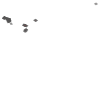

In [13]:
test_multi['multipolygon']

In [15]:
import ipyleaflet
from ipyleaflet import Map, basemaps, basemap_to_tiles, GeoJSON, WKTLayer
from ipywidgets import Label

# osmid = test.feature_df[test.feature_df['type']=='relation'].sample().iloc[0]['id']
# test_multi = test.generate_geometry('relation',osmid)

m = Map(
    basemap=basemaps.CartoDB.Positron,
    # for some reason lat lon are switch for centering the map
    center=((q_poly.centroid.coords[0][1],q_poly.centroid.coords[0][0])),
    #center=((test_multi['multipolygon'].centroid.coords[0][1],test_multi['multipolygon'].centroid.coords[0][0])),
    zoom=14
)

wlayer = WKTLayer(
    wkt_string=test_multi['multiline'].wkt,
    #hover_style={"fillColor": "red"},
    fill_color="red",
    color="red",
)

wlayer2 = WKTLayer(
    #wkt_string=Polygon([(cord[1],cord[0]) for cord in q_poly.exterior.coords]).wkt,
    wkt_string=Polygon(q_poly.exterior.coords).wkt,
    #hover_style={"fillColor": "red"},
    fill_color="blue",
    color="blue",

)

m.add_layer(wlayer)
m.add_layer(wlayer2)


# m.add_layer(geo_json)


m

Map(center=[48.19911188084065, 16.370350493313698], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [ ]:
# f_type= 'way'
# for e,item in enumerate(test.feature_df.loc[f_type].iterrows()):
#     if e % 1000 == 0:
#         print(e)
#     try:
#         test_multi = test.generate_geometry(f_type,item[0])
#     except:
#         print(item[0])
    